In [ ]:
# Importing the  required libraries:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf


In [ ]:
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler, normalize

In [ ]:
import os
import glob
import random
%matplotlib inline

In [ ]:
#Loading the dataset
data_map = []
for sub_dir_path in glob.glob("/content/drive/MyDrive/Mini Project/MRI Brain Images/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/content/drive/MyDrive/Mini Project/MRI Brain Images/README.md'
[Errno 20] Not a directory: '/content/drive/MyDrive/Mini Project/MRI Brain Images/data.csv'


In [ ]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...
1,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...
2,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...
3,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...
4,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...


In [ ]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = len("/content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif")
END_IMG_LEN =   len("/content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif")
END_MASK_LEN =  len("/content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif")

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : x[BASE_LEN:-END_IMG_LEN])
masks = sorted(df_masks["path"].values, key=lambda x : x[BASE_LEN:-END_MASK_LEN])

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_9.tif 
Path to the Mask: /content/drive/MyDrive/Mini Project/MRI Brain Images/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_8_mask.tif


In [ ]:
print(BASE_LEN,END_IMG_LEN,END_MASK_LEN)

109 109 114


In [ ]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,1
1,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,1
2,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,1
3,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,0
4,TCGA_CS_5397_20010315,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,0
...,...,...,...,...
3924,TCGA_HT_A616_19991226,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,0
3925,TCGA_HT_A616_19991226,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,0
3926,TCGA_HT_A616_19991226,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,0
3927,TCGA_HT_A616_19991226,/content/drive/MyDrive/Mini Project/MRI Brain ...,/content/drive/MyDrive/Mini Project/MRI Brain ...,0


In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
# Using plotly to plot an interactive bar chart:
import plotly.graph_objects as go

fig=go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color='rgb(0,200,0)', marker_line_color='rgb(0,255,0)', 
                 marker_line_width=3, opacity=0.6)
fig.show()

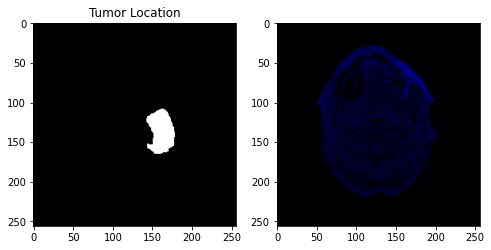

In [ ]:
# Showing an image:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [ ]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

In [ ]:
# Dropping the 'patient ID' column:
brain_df_train=brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
brain_df_train['mask']=brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


#Splitting the data into train, validate and test:

In [ ]:
from sklearn.model_selection import train_test_split

train, test=train_test_split(brain_df_train, test_size=0.15)

In [ ]:
# Creating an image data generator:
from keras_preprocessing.image import ImageDataGenerator

# Now I am creating a data generator which will scale the data from 0 to 1 and make a validation split of 20% :
datagen=ImageDataGenerator(rescale=1./255., validation_split=0.15)

In [ ]:
train, test = train_test_split(brain_df_train, test_size=0.15)
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.
